NCF uses neural network to model the interaction between users and items.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [3]:
import pandas as pd
# df = pd.read_csv('skin_dataset3.csv')
df = pd.read_csv('edited_rating4.csv')
df

,user_id,product_id,product_name,skin_type,rating,userId,product_idx
0,1,1,Vitamin C Serum,acne,0.9798,0,0
1,1,2,The Ordinary,acne,0.9798,0,1
2,1,3,niacinamide,acne,0.9798,0,2
3,1,4,salicylic acid,acne,0.9798,0,3
4,1,5,vitamin C,acne,0.9798,0,4
...,...,...,...,...,...,...,...
115243,23122,4,salicylic acid,acne,0.9872,23121,3
115244,23122,5,vitamin C,acne,0.9872,23121,4
115245,23123,15,cerave,acne,-0.8552,23122,14
115246,23123,4,salicylic acid,acne,-0.8552,23122,3


Epoch 1/10
721/721 [==============================] - 3s 5ms/step - loss: 0.4794 - mean_squared_error: 0.4794 - val_loss: 0.4634 - val_mean_squared_error: 0.4634
Epoch 2/10
721/721 [==============================] - 3s 5ms/step - loss: 0.3709 - mean_squared_error: 0.3709 - val_loss: 0.2623 - val_mean_squared_error: 0.2623
Epoch 3/10
721/721 [==============================] - 3s 4ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1278 - val_mean_squared_error: 0.1278
Epoch 4/10
721/721 [==============================] - 3s 5ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0653 - val_mean_squared_error: 0.0653
Epoch 5/10
721/721 [==============================] - 4s 5ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 6/10
721/721 [==============================] - 4s 5ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 7/10
721/721 [========

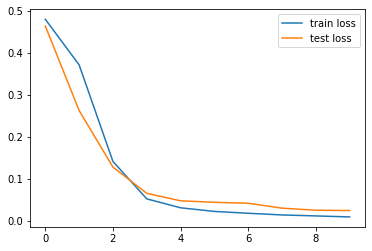

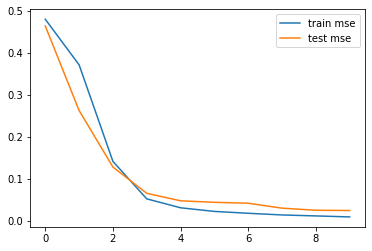

In [4]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

# load in the data
# df = pd.read_csv('amazon_beauty_edited_ratings.csv')

N = df.userId.max() + 1 # number of users
M = df.product_idx.max() + 1 # number of prouct

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 10
reg = 0.0001 # regularization penalty


# keras model
u = Input(shape=(1,), name='Users')
m = Input(shape=(1,), name='Items')
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(400)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mean_squared_error'],
)

r = model.fit(
  x=[df_train.userId.values, df_train.product_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.product_idx.values],
    df_test.rating.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()



In [5]:
model.evaluate([df_test.userId.values, df_test.product_idx.values], df_test.rating.values)

721/721 [==============================] - 1s 1ms/step - loss: 0.3142 - mean_squared_error: 0.3142


[0.31415855884552, 0.31415855884552]

# Recommending Products

In [6]:
predictions = model.predict([df_test.userId.values, df_test.product_idx.values])

[print(predictions[i], df_test.rating.iloc[i]) for i in range(0,8)]
# [print(predictions[2], df_test.rating.iloc[2])]

[0.41215542] 0.9990000000000001
[-1.2031271] -0.2223
[0.05370009] 0.7514
[0.41461867] 0.9972
[0.39499652] 0.986
[0.3738606] 0.9940000000000001
[0.3988468] 0.8201
[0.41417596] 0.9617


[None, None, None, None, None, None, None, None]

In [ ]:
# import tensorflow as tf
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True
# )

# Recommending products

In [7]:
dataset = pd.read_csv('edited_rating4.csv')


In [ ]:
productdata = np.array(list(set(dataset.product_idx)))
productdata

In [ ]:
userdata = np.array([6 for i in range(len(productdata))])
userdata

In [10]:
predictions = model.predict([userdata, productdata])
predictions = np.array([a[0] for a in predictions])

recommendedproducts = (-predictions).argsort()[:8]
recommendedproducts

array([767, 455, 311, 741, 813, 420, 645, 484])

In [11]:
predictions[recommendedproducts]

array([0.4222728 , 0.41980737, 0.419567  , 0.41954276, 0.41931012,
       0.4192974 , 0.41917273, 0.41908205], dtype=float32)

dictionary of products and their index

## Recommending products

In [ ]:
id_prod = {}
for num in set(dataset['product_idx']):
    d = dataset[dataset['product_idx'] == num]
    prod_name = list(set(d['product_name']))[0]
    id_prod[num] = prod_name
id_prod

In [13]:
recs = []
for num in recommendedproducts:
    recs.append(id_prod[num])

In [14]:
# print("Showing recommendations for user: {}".format(userdata))
print('Top recommended products')
print('------------------------')
print(recs)

Top recommended products
------------------------
['Cerave SPF 30', 'flax', 'cosrx 96 snail mucin', 'isopropyl palmitate', 'eucalyptus oil', 'shea butter', 'Watermelon Glow Sleeping Mask', 'azulene']
